In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style
from datetime import datetime

from sklearn.model_selection import TimeSeriesSplit

set_style("whitegrid")

In [39]:
appl = yf.Ticker("AAPL")
df = appl.history(period="10y").reset_index().copy() #taking 10 years of stock data

In [40]:
df['Date'] = df['Date'].dt.strftime('%m/%d/%Y') #removing time from date and converting to string
df['Date'] = pd.to_datetime(df['Date'])  #converting back to date object
df = df[["Date","Close"]]
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [41]:
df_train = df[(df['Date']>datetime(2019,1,1))&(df['Date']<=datetime(2022,12,31))]
df_test = df[(df['Date']>datetime(2023,1,1))&(df['Date']<=datetime(2023,12,31))]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


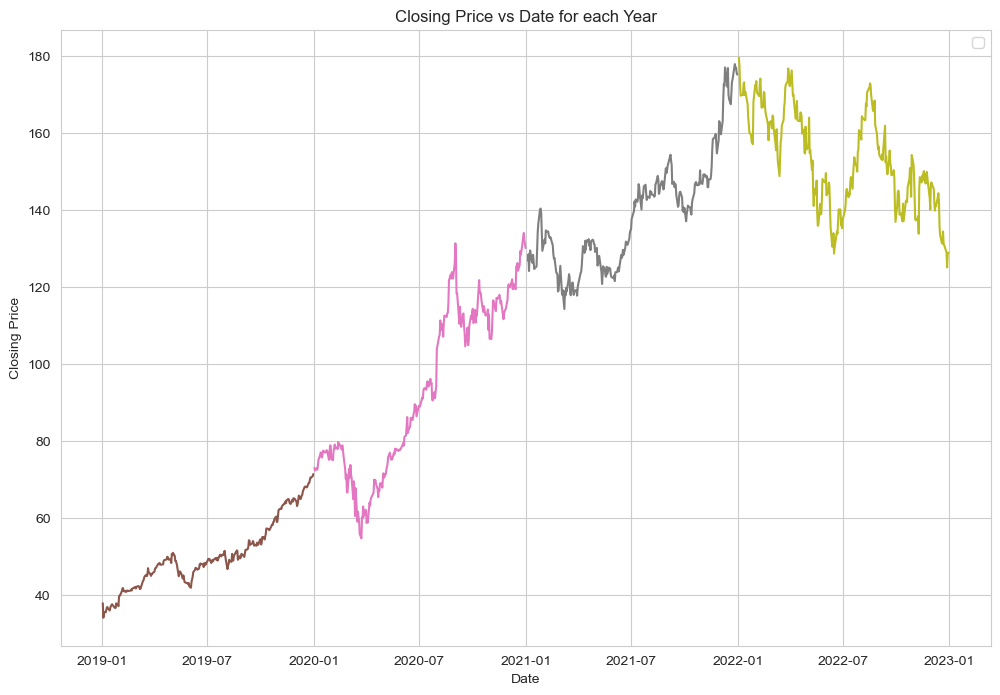

In [42]:
plt.figure(figsize=(12,8))

for year in df['Year'].unique():
    yearly_data = df_train[df_train['Year']==year]
    plt.plot(yearly_data['Date'], yearly_data['Close'])

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price vs Date for each Year')
plt.legend()

Baseline

In [112]:
# return the mean absolute error of the prediction on the test data 
# relative to mean absolute error of the naive prediction on the training data
# If MASE > 1 then the prediction performs worse out of sample than naive forecast does in sample.
# If MASE < 1 then the prediction performs better out of sample than naive forecast does in sample.

def mase(y_train_past, y_train, y_test, y_preds):
    n = len(y_train_past)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        past_val = y_train[i]
        future_val = y_train[i+m+1]
        interpolation = np.linspace(past_val,future_val, m+2)[1:-1]
        
        denom += np.abs(y_train[i+1:i+m+1] - interpolation).mean()
        #print("past_value_0:",past_val, "interpolation_0:", interpolation,"true_value_0:",y_train[i+1:i+m+1], "future_value_0", future_val)
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom 

Rolling average model

In [113]:
cv = TimeSeriesSplit(100, test_size=1)
start = 1
end = 30
ra_mase = np.zeros((100, len(range(start,end))))

i=0
for train_past_index, test_index in cv.split(df_train[:round(len(df_train)/2-1)]): #df_train[:1000]
    max_index = len(df_train) - 1
    future_length = len(train_past_index)
    train_future_index = np.arange(test_index[-1] + 1, test_index[-1] + 1 + future_length)
    train_future_index = train_future_index[train_future_index <= max_index][::-1]

    past_tt = df_train.iloc[train_past_index]
    future_tt = df_train.iloc[train_future_index]#.reset_index().copy()
    hold_out = df_train.iloc[test_index]

    j = 0
    for q in range(start, end):
        # pred = past_tt.Close[-q:].mean() * np.ones(len(hold_out))
        pred = np.mean([past_tt.Close.values[-q:].mean() * np.ones(len(hold_out)),
                        future_tt.Close.values[-q:].mean() * np.ones(len(hold_out))], axis=0)
        
        # my_average = (past_tt.Close.values[-1]+future_tt.Close.values[-1])/2
        #if q==1: print("past_value:", past_tt.Close.values[-1], "future_value", future_tt.Close.values[-1], "prediction:",pred, "average:", (past_tt.Close.values[-1]+future_tt.Close.values[-1])/2)

        ra_mase[i,j] = mase(past_tt.Close.values, df_train.Close.values, hold_out.Close.values, pred)
        j = j+1
    i = i+1

    # print("past_train:", train_past_index[-5:], "test:", test_index, "future_train:", train_future_index[-5:])
    # print("past_train_len:", len(train_past_index), "test_len:", len(test_index), "future_train_len:", len(train_future_index))

    
 

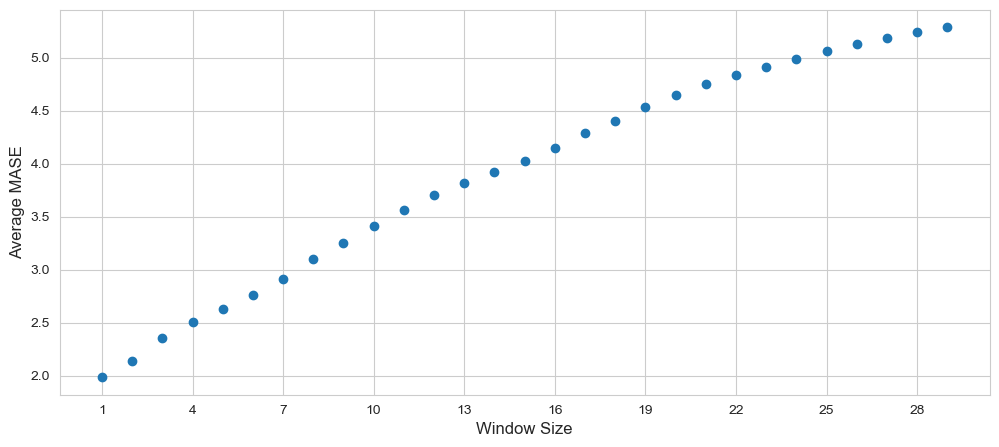

In [114]:
plt.figure(figsize=(12,5))

plt.scatter(range(start,end), np.mean(ra_mase, axis=0))

plt.xlabel("Window Size", fontsize=12)
plt.ylabel("Average MASE", fontsize=12)

plt.xticks(range(start, end, 3), fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [104]:
print("The window size that minimized the avg. cv MASE",
      "was q =", 
      range(start,end)[np.argmin(np.mean(ra_mase, axis=0))],
      "\b.",
      "It had a mean cv MASE of", 
      np.round(np.min(np.mean(ra_mase, axis=0)), 3))

The window size that minimized the avg. cv MASE was q = 1. It had a mean cv MASE of 1.764


A double exponential Smoothing Model

In [89]:
from statsmodels.tsa.holtwinters import Holt

In [90]:
cv = TimeSeriesSplit(10, test_size=1)
exp_mase = np.zeros((10, len(np.arange(0,0.2,0.01)), len(np.arange(0,0.2,0.01))))

i = 0
for train_past_index, test_index in cv.split(df_train[:round(len(df_train)/2-1)]): 
    max_index = len(df_train) - 1
    future_length = len(train_past_index)
    train_future_index = np.arange(test_index[-1] + 1, test_index[-1] + 1 + future_length)
    train_future_index = train_future_index[train_future_index <= max_index][::-1]

    past_tt = df_train.iloc[train_past_index]
    future_tt = df_train.iloc[train_future_index].reset_index().copy()
    hold_out = df_train.iloc[test_index]

    j = 0
    for alpha in np.arange(0,0.2,0.01):
        k = 0
        for beta in np.arange(0,0.2,0.01):
            exp_smooth_past = Holt(past_tt.Close.values).fit(smoothing_level=alpha,
                                                             smoothing_trend=beta,
                                                             optimized=False)
            exp_smooth_future = Holt(future_tt.Close.values).fit(smoothing_level=alpha,
                                                                 smoothing_trend=beta,
                                                                 optimized=False)
            
            impute_from_past = exp_smooth_past.forecast(len(hold_out))
            impute_from_future = exp_smooth_future.forecast(len(hold_out))[::-1]
            pred = [(impute_from_past[ii]+impute_from_future[ii])/2 for ii in range(len(impute_from_future))]

            #print("impute from past", impute_from_past, "impute_from_future", impute_from_future)
            exp_mase[i,j,k] = mase(past_tt.Close.values, future_tt.Close.values, hold_out.Close.values, pred)
            k = k +1
        j = j + 1
    i = i + 1
            
    

KeyboardInterrupt: 